# Sentiment Analysis in Python

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from HuggingFace
3. Huggingface Pipeline

In [10]:
# Import initial necessary libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk

# Settings of dataframe display
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = None

# Version requirements
print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.26.4
pandas version :  2.2.1
seaborn version :  0.13.2


In [75]:
df = pd.read_csv("Reviews.csv")

## Quick EDA

In [8]:
df.sample(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
346581,346582,B0002Y2TWQ,AK55K92MB2GET,Damian J. Gomez,2,2,3,1346630400,My Dog Doesn't Like Them,"I thought she would love them, really high quality USA produced smoked pig ear and would be my first choice if I had to chew on something all day. Seems great for a big chewer."
267282,267283,B000X1SQ3O,AFFIMOKIENRN1,B. Bubier,5,5,4,1259798400,A classic toy! but smaller than when I was a kid,"I bought these for my kids. They love them, having never before experienced the fun of a Super Ball.<br />Wham-O has made the balls somewhat smaller than when I was a kid in the late 1960's. This doesn't affect the fun, but I do think they may have bounce more/longer when they were bigger, way back when.<br />They are totally cool. A classic toy every kid should enjoy. The shipping was quick and the packaging was adequate. Buy with confidence."
119311,119312,B003Z7VYXW,A307VPQTIOLSU9,Ted,0,0,5,1299628800,The best yeast,"This yeast is great. I store it frozen. I find it the best for my bread baking and pizza dough.<br />Also, this is the best price I've found for this great yeast."


In [9]:
df.shape

(568454, 10)

In [18]:
df["Score"].value_counts()

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

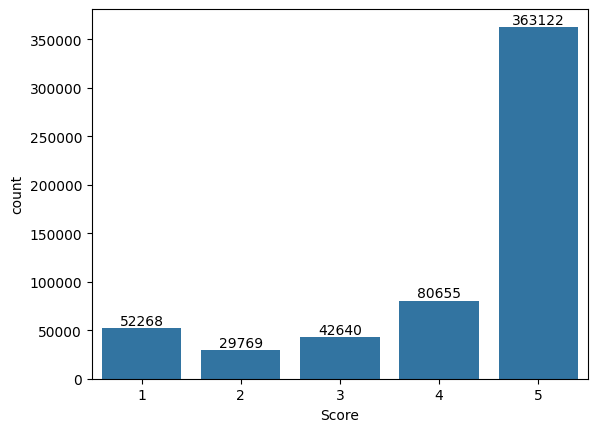

In [19]:
# Create the countplot
ax = sns.countplot(data=df, x="Score")

# Add labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, label_type='edge')

## Basic NLTK

In [20]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [24]:
example = df["Text"][50]

In [27]:
# Tokenization
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [29]:
# Pos-tagging
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [33]:
# Entity recognition
entity = nltk.chunk.ne_chunk(tagged)
entity.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1. VADER Sentiment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [56]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

sia = SentimentIntensityAnalyzer()

In [43]:
?tqdm

Init signature: tqdm(*args, **kwargs)
Docstring:      Experimental IPython/Jupyter Notebook widget using tqdm!
Init docstring:
Supports the usual `tqdm.tqdm` parameters as well as those listed below.

Parameters
----------
display  : Whether to call `display(self.container)` immediately
    [default: True].
File:           c:\users\cikal merdeka\appdata\local\programs\python\python312\lib\site-packages\tqdm\notebook.py
Type:           type
Subclasses:     

In [64]:
# Experiment with tqdm
from tqdm import tqdm
import time

# # Example 1: Basic usage with a for loop
# for i in tqdm(range(100)):
#     time.sleep(0.1)  # Simulate some work

# # Example 2: Using tqdm with a list
# my_list = [1, 2, 3, 4, 5]
# for item in tqdm(my_list, desc="Processing items"):
#     print(item)
#     time.sleep(0.5)  # Simulate processing each item

# # Example 3: Manual control of the progress bar
# with tqdm(total=100) as pbar:
#     for i in range(10):
#         time.sleep(0.1)
#         pbar.update(10)

# Example 4: Using tqdm with pandas DataFrame
import pandas as pd

df = pd.DataFrame({'A': range(1000), 'B': range(1000)})
result = {}
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing DataFrame"):
    # Simulate some processing
    result[index] = row['A'] * row['B']
    time.sleep(0.01)

# # Example 5: Nested progress bars
# for i in tqdm(range(10), desc="Outer loop"):
#     for j in tqdm(range(10), desc=f"Inner loop {i}", leave=False):
#         time.sleep(0.1)

Processing DataFrame: 100%|██████████| 1000/1000 [00:11<00:00, 88.63it/s]


Certainly! The `tqdm` library is primarily used to add progress bars to loops or iterative processes in Python. It's especially useful when you're dealing with long-running operations and want to visualize the progress.

Let me explain these examples:

1. Basic usage: This shows how to wrap a simple for loop with tqdm. It will display a progress bar as the loop progresses.

2. Using with a list: Here, we're iterating over a list. The `desc` parameter adds a description to the progress bar.

3. Manual control: This demonstrates how to manually update the progress bar when you can't use it directly with a loop.

4. With pandas DataFrame: This is similar to your original code, showing how to use tqdm when iterating over a DataFrame.

5. Nested progress bars: This shows how to display progress bars for nested loops.

In each case, `tqdm` wraps an iterable and returns an iterator which displays a progress meter and updates it every time you iterate.

The main benefits of using `tqdm` are:
1. It gives users visual feedback on long-running operations.
2. It can estimate the time remaining for a process to complete.
3. It's easy to implement and doesn't significantly slow down your code.

Would you like me to explain any of these examples in more detail?

In [38]:
# Testing nltk sentiment intensity analyzer funtion

words = "I am so happy"
sia.polarity_scores(words)

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [39]:
words = "This is the worst thing ever."
sia.polarity_scores(words)

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [42]:
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [57]:
# Run the polarity score on the entire dataset

res = {}

for i, row in tqdm(df.iterrows(), total=len(df)) :
    text = row["Text"]
    myid = row["Id"]
    res[myid] = sia.polarity_scores(text)

100%|██████████| 568454/568454 [06:43<00:00, 1408.30it/s]


In [58]:
res

{1: {'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441},
 2: {'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'compound': -0.5664},
 3: {'neg': 0.091, 'neu': 0.754, 'pos': 0.155, 'compound': 0.8265},
 4: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 5: {'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'compound': 0.9468},
 6: {'neg': 0.029, 'neu': 0.809, 'pos': 0.163, 'compound': 0.883},
 7: {'neg': 0.034, 'neu': 0.693, 'pos': 0.273, 'compound': 0.9346},
 8: {'neg': 0.0, 'neu': 0.52, 'pos': 0.48, 'compound': 0.9487},
 9: {'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.6369},
 10: {'neg': 0.0, 'neu': 0.705, 'pos': 0.295, 'compound': 0.8313},
 11: {'neg': 0.017, 'neu': 0.846, 'pos': 0.137, 'compound': 0.9746},
 12: {'neg': 0.113, 'neu': 0.887, 'pos': 0.0, 'compound': -0.7579},
 13: {'neg': 0.031, 'neu': 0.923, 'pos': 0.046, 'compound': 0.296},
 14: {'neg': 0.0, 'neu': 0.355, 'pos': 0.645, 'compound': 0.9466},
 15: {'neg': 0.104, 'neu': 0.632, 'pos': 0.264, 'compound': 0.6486},
 

In [62]:
len(res)

568454

In [59]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [60]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch."
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


## Plot VADER results

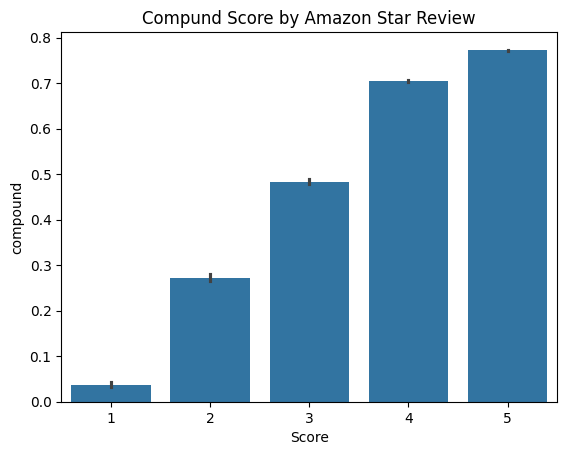

In [61]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

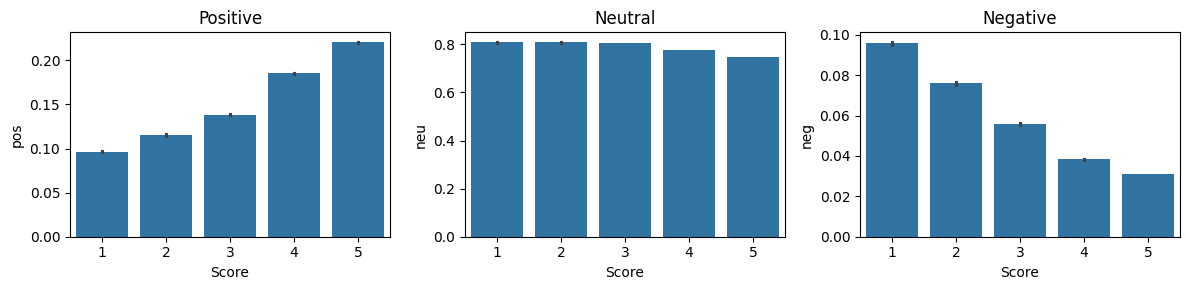

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axes[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axes[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axes[2])
axes[0].set_title('Positive')
axes[1].set_title('Neutral')
axes[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [68]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [69]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [70]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [71]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687453, 'roberta_pos': 0.0029573678}


In [72]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [76]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 84/568454 [00:09<27:05:47,  5.83it/s]

Broke for id 83


  0%|          | 189/568454 [00:20<13:21:13, 11.82it/s]

Broke for id 187


  0%|          | 530/568454 [01:01<22:57:55,  6.87it/s]

Broke for id 529


  0%|          | 541/568454 [01:02<14:29:03, 10.89it/s]

Broke for id 540


  0%|          | 566/568454 [01:06<18:23:47,  8.57it/s]


KeyboardInterrupt: 

Take way too long so we will stop for now.

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [77]:
from transformers import pipeline

sent_pipeline = pipeline(task="sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [80]:
?pipeline

Signature:
pipeline(
    task: str = None,
    model: Union[str, ForwardRef('PreTrainedModel'), ForwardRef('TFPreTrainedModel'), NoneType] = None,
    config: Union[str, transformers.configuration_utils.PretrainedConfig, NoneType] = None,
    tokenizer: Union[str, transformers.tokenization_utils.PreTrainedTokenizer, ForwardRef('PreTrainedTokenizerFast'), NoneType] = None,
    feature_extractor: Union[str, ForwardRef('SequenceFeatureExtractor'), NoneType] = None,
    image_processor: Union[str, transformers.image_processing_utils.BaseImageProcessor, NoneType] = None,
    framework: Optional[str] = None,
    revision: Optional[str] = None,
    use_fast: bool = True,
    token: Union[str, bool, NoneType] = None,
    device: Union[int, str, ForwardRef('torch.device'), NoneType] = None,
    device_map=None,
    torch_dtype=None,
    trust_remote_code: Optional[bool] = None,
    model_kwargs: Dict[str, Any] = None,
    pipeline_class: Optional[Any] = None,
    **kwargs,
) -> transformers.pip

In [78]:
# Check sentiment polarity score
sentence_to_analyze = 'I love sentiment analysis!'
sent_pipeline(sentence_to_analyze)

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [79]:
sentence_to_analyze = "I hate this product, it's very old and stinky"
sent_pipeline(sentence_to_analyze)

[{'label': 'NEGATIVE', 'score': 0.9997950196266174}]